# Project 1 - Part 2

## Implementation Description
**Code references/inspiration:**
- The e-book *[Algorithms for Optimization]*  
  (pp. 157–165): https://algorithmsbook.com/
- Documentation for Julia and packages (listed below)
- Lecture slides
- EvoLP
- Gemini has been used to help optimize some of the Julia code

## Setup Jupyter and Install dependencies

#### Run to create a new Jupyter kernel with max number of threads
**Instructions:**
1. Uncomment and run the code below to create a multi-threaded kernel for jupyter
2. Select the new kernel in jupyter: Kernel -> change kernel
3. Restart the kernel

In [1]:

"""
using IJulia

#installkernel("Julia (Auto Threads)", env=Dict("JULIA_NUM_THREADS" => "auto"))
"""

"using IJulia\n\n#installkernel(\"Julia (Auto Threads)\", env=Dict(\"JULIA_NUM_THREADS\" => \"auto\"))\n"

#### Run to check and install missing dependencies

In [2]:
"""
using Pkg
# Packages required for project
dependencies = [
    "CSV", 
    "DataFrames", 
    "Random", 
    "LinearAlgebra", 
    "StatsBase", 
    "Printf", 
    "Plots",
    "PlotlyJS",
    "ProgressMeter",
]

# Check each package and install if not found in the current environment
for pkg in dependencies
    if !haskey(Pkg.dependencies(), pkg)
        Pkg.add(pkg)
    end
end
"""

"using Pkg\n# Packages required for project\ndependencies = [\n    \"CSV\", \n    \"DataFrames\", \n    \"Random\", \n    \"LinearAlgebra\", \n    \"StatsBase\", \n    \"Printf\", \n    \"Plots\",\n    \"PlotlyJS\",\n    \"ProgressMeter\",\n]\n\n# Check each package and install if not found in the current environment\nfor pkg in dependencies\n    if !haskey(Pkg.dependencies(), pkg)\n        Pkg.add(pkg)\n    end\nend\n"

## Main imports

In [3]:
using CSV
using DataFrames

using Random
using LinearAlgebra
using StatsBase

using Printf
using Plots
using ProgressMeter


# Use Plotly as plotting-backend
plotly();

## GA implementation

#### Problem definition

In [4]:
abstract type Problem end

# Problem definition
struct KnapsackProblem <: Problem
    profits::Vector{Int}
    weights::Vector{Int}
    capacity::Int
end

#### Operator types

In [5]:
abstract type PopulationGenerator end
abstract type ParentSelectionMethod end
abstract type CrossoverMethod end
abstract type MutationMethod end
abstract type SurvivorSelectionMethod end

#### Population Generators

In [28]:
using Random

struct UniformRandomPopulationGenerator <: PopulationGenerator end    

"""
Generates an initial population of uniformly random bitstrings with RNG to produce same population.
"""
function initialize(
        method::UniformRandomPopulationGenerator,
        chrom_len::Int,
        population_size::Int,
        rng::AbstractRNG = Random.default_rng() # Default to global RNG if not provided
    )::Vector{BitVector}
    
    return [bitrand(rng, chrom_len) for _ in 1:population_size]
end

initialize

#### Selection methods
All methods return both the selected parents and their fitnesses, so these don't have to be recomputed in the solver.

In [7]:
struct RouletteWheelSelectionMin <: ParentSelectionMethod end
struct TournamentSelectionMin <: ParentSelectionMethod
    k::Int # Touornament size (number of contestants to test fitness against for each round)
end

"""
NOTE!
All the selection methods below operate on lists.
select() takes a list of parents and returns a list of the selected individuals.
"""


"""
Tournament selection (minimizing).
"""
function select(
        method::TournamentSelectionMin,
        parents::Vector{BitVector},
        fitnesses::Vector{Float64}
)::Tuple{Vector{BitVector}, Vector{Float64}}
    
    pop_size = length(parents)
    num_winners = pop_size
    
    winners = Vector{BitVector}(undef, num_winners)
    winner_fits = Vector{Float64}(undef, num_winners)
    
    for i in 1:num_winners
        # Randomly pick k indices of individuals
        tournament_indices = sample(1:pop_size, method.k, replace=false)
        
        # Get index of the tournament winner (min fitness)
        winner_idx = tournament_indices[argmin(fitnesses[tournament_indices])]
        
        winners[i] = parents[winner_idx]
        winner_fits[i] = fitnesses[winner_idx]
    end
    return winners, winner_fits
end


"""
Roulette wheel selection (minimizing).
"""
function select(
        method::RouletteWheelSelectionMin,
        parents::Vector{BitVector},
        fitnesses::Vector{Float64}
)::Tuple{Vector{BitVector}, Vector{Float64}}
    max_fit = maximum(fitnesses)
    min_fit = minimum(fitnesses)
    
    epsilon = (max_fit - min_fit) * 0.01 + 1e-6
    offset_fitnesses = (max_fit .+ epsilon) .- fitnesses # Inverts fitnesses (e.g. min fit -> max fit and vice versa)

    probabilities = Weights(offset_fitnesses)

    idx_pool = 1:length(parents)
    selected_indices = sample(idx_pool, probabilities, length(parents))
    
    return parents[selected_indices], fitnesses[selected_indices]
end

select

#### Crossover methods

In [8]:
struct SinglePointCrossover <: CrossoverMethod end
struct UniformCrossover <: CrossoverMethod end

"""
NOTE!
All the crossover methods operate on individuals, not lists (entire population).
The methods all accept two parents and return two children.
"""


"""
Single point crossover.
Takes two parents and returns two children.
"""
function crossover(method::SinglePointCrossover, parent1::BitVector, parent2::BitVector, p_c::Float64)::Vector{BitVector}
    if rand() < p_c
        return [parent1, parent2]
    end
    n = length(parent1)
    i = rand(1:n-1) # Random crossover point

    child1 = vcat(parent1[1:i], parent2[i+1:n])
    child2 = vcat(parent2[1:i], parent1[i+1:n])

    return [child1, child2]
end

"""
Uniform crossover.
Every bit has a 50% chance of being swapped between the parents.
"""
function crossover(method::UniformCrossover, parent1::BitVector, parent2::BitVector, p_c::Float64)::Vector{BitVector}
    if rand() > p_c
        return [parent1, parent2]
    end
    
    child1 = copy(parent1)
    child2 = copy(parent2)

    for i in 1:length(parent1)
        if rand() < 0.5
            # Swap bits with 50% chance
            child1[i] = parent2[i]
            child2[i] = parent1[i]
        end
    end

    return [child1, child2]
end

crossover

#### Mutation methods

In [9]:
struct BitFlipMutation <: MutationMethod end

"""
Bitwise mutation in place.
Flips each bit with probability p_m.
"""
function mutate(method::BitFlipMutation, chromosome::BitVector, p_m::Float64)::BitVector
    # Copy, so we don't change parents
    mutated_chromosome = copy(chromosome)
    
    for i in eachindex(mutated_chromosome)
        if rand() < p_m
            mutated_chromosome[i] = !mutated_chromosome[i]
        end
    end
    
    return mutated_chromosome
end

mutate

#### Survivor selection methods
All methods return both the new population and the fitnesses (so they don't have to be computed twice in the solver)

In [10]:
struct GenerationalReplacement <: SurvivorSelectionMethod end
struct TruncationSelectionMin <: SurvivorSelectionMethod end
struct ElitismReplacementMin <: SurvivorSelectionMethod
    n_elites
end

"""
Replaces population with offspring.
"""
function survive(method::GenerationalReplacement, old_pop, offspring, old_fits, new_fits)
    return offspring, new_fits
end

"""
Replaces population with offspring, but keeps n_elites min fitness individuals from parents.
"""
function survive(method::ElitismReplacementMin, old_pop, offspring, old_fits, new_fits)
    n_elites = method.n_elites
    
    # Get elite parent indices
    elite_indices = partialsortperm(old_fits, 1:n_elites, rev=false)
    
    # Get indices of worst offspring
    worst_offspring_indices = partialsortperm(new_fits, 1:n_elites, rev=true)

    # Init new population to a copy of the offspring
    new_pop = copy(offspring)
    final_fits = copy(new_fits)

    # Replace worst offspring with elites
    for i in 1:n_elites
        idx_to_replace = worst_offspring_indices[i]
        new_pop[idx_to_replace] = old_pop[elite_indices[i]]
        # Update fitness
        final_fits[idx_to_replace] = old_fits[elite_indices[i]]
    end
    
    return new_pop, final_fits
end

function survive(method::TruncationSelectionMin, old_pop, offspring, old_fits, new_fits)
    # Pool/concat parents and offspring
    combined_pop = vcat(old_pop, offspring)
    combined_fits = vcat(old_fits, new_fits)
    
    # Get indices of the fittest individuals
    pop_size = length(old_pop)
    best_indices = partialsortperm(combined_fits, 1:pop_size, rev=false)
    
    return combined_pop[best_indices], combined_fits[best_indices]
end

survive (generic function with 3 methods)

#### Genetic Algorithm struct (combines operators and hyperparameters)

In [11]:
# Store hyperparams together in struct

# Base.@kwdef makes it possible to use the field names when using the struct, instead of just having positional args.
Base.@kwdef struct GeneticAlgorithm
    p_c::Float64 # Probability of crossover
    p_m::Float64 # Probability of mutation
    
    pop_size::Int
    max_generations::Int
    chrom_len::Int

    generator::PopulationGenerator
    selector::ParentSelectionMethod
    crossover::CrossoverMethod
    mutator::MutationMethod
    survivor::SurvivorSelectionMethod
end;

### Utils: Logger and plotting functions

#### Logger

In [12]:
mutable struct GAResults
    max_fit_chrom::BitVector
    min_fit_chrom::BitVector
    max_fit::Float64
    min_fit::Float64
    hist_max::Vector{Float64}
    hist_mean::Vector{Float64}
    hist_min::Vector{Float64}
    hist_entropy::Vector{Float64}
    final_pop::Vector{BitVector}
end

# Constructor to initialize results-log
function GAResults(chrom_len::Int)
    # Initialize empty logger
    return GAResults(
        falses(chrom_len), # all zeroes bitstring
        falses(chrom_len), # all zeroes bitstring
        -Inf,                      # -inf fitness
        Inf,                      # inf fitness
        Float64[], Float64[], Float64[], # Empty histories
        Float64[], # track entropy
        BitVector[]               # Empty final_pop
    )
end


function log_statistics!(logger::GAResults, population, fitnesses)
    # Calculate stats for this generation
    current_max = maximum(fitnesses)
    current_mean = sum(fitnesses) / length(fitnesses)
    current_min = minimum(fitnesses)

    # Update histories
    push!(logger.hist_max, current_max)
    push!(logger.hist_mean, current_mean)
    push!(logger.hist_min, current_min)
    
    # Update global max fit individual
    if current_max > logger.max_fit
        logger.max_fit = current_max
        logger.max_fit_chrom = copy(population[argmax(fitnesses)]) # store a copy, not ref
    end
    # Update global min fit individual
    if current_min < logger.min_fit
        logger.min_fit = current_min
        logger.min_fit_chrom = copy(population[argmin(fitnesses)]) # store a copy, not ref
    end

    # Entropy calculation (Optimized this part with help of Gemini to reduce RAM overhead from original solution)
    pop_size = length(population)
    chrom_len = length(population[1])
    current_entropy = 0.0
    
    for bit in 1:chrom_len # for every bit
        count = 0
        for ind in 1:pop_size # count # of times bit occured in population
            if population[ind][bit]
                count += 1
            end
        end
        p = count / pop_size # Get prob of bit
        if 0 < p < 1
            current_entropy -= (p * log2(p) + (1-p) * log2(1-p)) # update entropy
        end
    end
    push!(logger.hist_entropy, current_entropy)
end

function log_final_population!(logger::GAResults, population)
    logger.final_pop = deepcopy(population)
end

log_final_population! (generic function with 1 method)

#### Plotting utils

In [48]:
using Plots.Measures

"""
Plot max, mean, min fitness over generations.
"""
function plot_ga_convergence(result::GAResults)
    # Define the X-axis (Generations)
    gens = 1:length(result.hist_max)
    
    # Initialize the plot
    p = plot(title="Genetic Algorithm Convergence",
             xlabel="Generation",
             ylabel="Fitness",
             legend=:topright,
             grid=true,
             lw=2)
    
    # Add the three history lines
    plot!(p, gens, result.hist_max, label="Max Fitness", color=:green)
    plot!(p, gens, result.hist_mean, label="Mean Fitness", color=:blue)
    plot!(p, gens, result.hist_min, label="Min Fitness", color=:red, linestyle=:dash)
    
    return p
end

"""
Plot population entropy over generations.
"""
function plot_ga_entropy(result::GAResults)
    gens = 1:length(result.hist_entropy)
    
    p = plot(gens, result.hist_entropy,
             title="Population Diversity (Shannon Entropy)",
             xlabel="Generation",
             ylabel="Total Entropy (bits)",
             label="Entropy",
             color=:purple,
             lw=2,
             legend=:topright,
             grid=true)
    return p
end


"""
Print summary of results and show convergence and entropy plots.
"""
function print_and_plot_results(result::GAResults)
    @printf("Best Solution: %s\n", join(Int.(result.min_fit_chrom)))
    @printf("Best Fitness:  %.3f\n", result.min_fit)
    @printf("Improvement: %.3f -> %.3f\n", result.hist_max[1], result.min_fit)

    # Plot
    p = plot_ga_convergence(result)
    display(p)

    p = plot_ga_entropy(result)
    display(p)
end


function plot_ga_summary(result::GAResults, run_name::String="GA Run Analysis")
    gens = 1:length(result.hist_max)

    # 1. Create the Convergence Plot
    p1 = plot(gens, result.hist_max, label="Max Fitness", color=:green, lw=2)
    plot!(p1, gens, result.hist_mean, label="Mean", color=:blue, lw=2)
    plot!(p1, gens, result.hist_min, label="Min", color=:red, lw=2, linestyle=:dash)
    # Explicitly set title and legend for THIS subplot
    plot!(p1, title="Convergence", xlabel="Generation", ylabel="Fitness", legend=:topright)

    # 2. Create the Entropy Plot
    p2 = plot(gens, result.hist_entropy, label="Shannon Entropy", color=:purple, lw=2)
    # Explicitly set title and legend for THIS subplot
    plot!(p2, title="Diversity", xlabel="Generation", ylabel="Entropy", legend=:topright)

    # 3. Use the 'link' attribute to ensure they are treated as separate subplots
    # while still sharing a layout. 
    combined = plot(p1, p2, 
        layout = grid(1, 2), 
        size = (1100, 500),
        plot_title = run_name,
        margin = 10mm,
        # 'link = :none' ensures that axis/legend logic isn't shared
        link = :none 
    )

    return combined
end


"""
Creates and saves a combined plot of fitness and entropy to file.
"""
function save_combined_results_plot(results, file_path::String)
    p1 = plot_ga_convergence(results)
    p2 = plot_ga_entropy(results)
    
    combined_plot = plot(p1, p2, 
        layout = (1, 2), 
        margin = 10mm,       # Adds space around all sides of both plots
        size = (1000, 600),    # Adjusting size helps prevent labels from overlapping
        legend=:right,
        legend_font_pointsize = 8
    )
    
    savefig(combined_plot, file_path)
    
    return combined_plot
end

save_combined_results_plot

### GA solver implementation

#### Function for simulating one generation of genetic algorithm

In [37]:
function generation(
        old_pop::Vector{BitVector},
        old_fits::Vector{Float64},
        problem::Problem,
        GA::GeneticAlgorithm
)::Tuple{Vector{BitVector}, Vector{Float64}}
    
    # Select Parents
    selected_parents, selected_fits = select(GA.selector, old_pop, old_fits)
    
    # Shuffle parents (and fitnesses so they match)
    shuffled_idx = shuffle(1:length(selected_parents))
    selected_parents = selected_parents[shuffled_idx]
    selected_fits = selected_fits[shuffled_idx]

    # Split parents into two vectors for broadcasting with crossover function
    parents1 = selected_parents[1:2:end]
    parents2 = selected_parents[2:2:end]

    # Crossover
    offspring = crossover.(Ref(GA.crossover), parents1, parents2, Ref(GA.p_c)) # returns list of pairs of offspring
    offspring = collect(Iterators.flatten(offspring)) # flatten

    # Mutate the offspring
    offspring = mutate.(Ref(GA.mutator), offspring, Ref(GA.p_m))

    # Evaluate offspring fitness with multi-threading
    n_offspring = length(offspring)
    offspring_fits = Vector{Float64}(undef, n_offspring)
    Threads.@threads for i in 1:n_offspring
        # Each thread works on a different index to make it thread safe
        offspring_fits[i] = fitness(problem, offspring[i])
    end
    
    # Survivor selection
    new_pop, new_fits = survive(GA.survivor, old_pop, offspring, old_fits, offspring_fits)

    return new_pop, new_fits
end

generation (generic function with 1 method)

#### Solver function (runs entire GA simulation)
Runs a genetic algorithm config on a selected problem and returns a results object (logged stats).

In [38]:
"""
Solver function for running genetic algorithm.

Returns logged results as struct of type GAResults.
"""
function solve(problem::Problem, GA::GeneticAlgorithm)::GAResults
    # Setup: Initialize logger
    result_log = GAResults(GA.chrom_len)
    
    # 1. Initialize population
    old_pop = initialize(GA.generator, GA.chrom_len, GA.pop_size, MersenneTwister(123))
    
    # 2. Evaluate initial fitnessses
    fitnesses = fitness.(Ref(problem), old_pop)

    @showprogress "Computing generations" for gen in 1:GA.max_generations
        # Log
        log_statistics!(result_log, old_pop, fitnesses)
        
        # 3. Run one generation
        new_pop, new_fits = generation(old_pop, fitnesses, problem, GA)

        # 4. Update population and fitnesses
        old_pop = new_pop
        fitnesses = new_fits
    end
    log_final_population!(result_log, old_pop)
    return result_log
end

solve

# Part 2

## Setup: Load data and initialise ML model

#### Imports

In [39]:
using CSV
using DataFrames
using Random
using StableRNGs
using MLJ: predict

# Include LinReg.jl
lin_reg_path = joinpath("IT3708 - Files for Project 1", "feature_selection", "LinReg.jl")
include(lin_reg_path);

#### Load dataset

In [40]:
# Load dataset to dataframe
dataset_path = joinpath("IT3708 - Files for Project 1", "feature_selection", "dataset.txt")
data_df = CSV.read(dataset_path, DataFrame, header=0);

# Unpack features and target columns
y_raw, X_raw = unpack(data_df, ==(:Column102));

# Force correct datatypes for MLJ (changes when CSV is running in multi-threaded mode)
const X = DataFrame(X_raw);
const y = collect(y_raw);

#### Initialize linear regressor

In [41]:
# Load global linear regressor model
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels verbosity=0
const model = LinearRegressor();

## GA code for part 2

### Fitness and problem definition

In [42]:
# Problem struct
struct FeatureSelectionProblem <: Problem
    n_features::Int
    X # Column data
    y # Target
    rng # RNG
    model # Linear regressor
end

# Fitness function
function fitness(P::FeatureSelectionProblem, x)::Float64
    X_sub = get_columns(P.X, x);
    get_fitness(P.model, X_sub, P.y, rng=P.rng);
end

fitness (generic function with 1 method)

### Crowding methods

In [43]:
"""
Gets hamming distance between two BitVectors.
"""
function dist(x1::BitVector, x2::BitVector)
    # .⊻ is the broadcasted XOR operator
    return count(x1 .⊻ x2) 
end


struct DeterministicCrowdingSelectionMin <: SurvivorSelectionMethod end
struct ProbabilisticCrowdingSelectionMin <: SurvivorSelectionMethod end

"""
Probabilistic crowding.
"""
function survive(
        method::ProbabilisticCrowdingSelectionMin,
        old_pop::Vector{BitVector},
        offspring::Vector{BitVector},
        old_fits::Vector{Float64},
        offspring_fits::Vector{Float64}
    ) # Removed rigid return type for flexibility
    
    # Initialize new population with offspring
    new_pop = copy(offspring)
    final_fits = copy(offspring_fits)

    # Add epsilon to prevent divide by zero
    eps = 1e-10
    
    # Iterate in steps of 2 (processing 2 Parents & 2 Children at a time)
    for i = 1:2:length(old_pop)
        j = i + 1
        
        # Identify the Family
        p1, p2 = old_pop[i], old_pop[j]
        c1, c2 = offspring[i], offspring[j]
        
        p1_f, p2_f = old_fits[i], old_fits[j]
        c1_f, c2_f = offspring_fits[i], offspring_fits[j]

        # Calculate Distances
        # d1 = P1 vs C1, P2 vs C2 (Direct)
        # d2 = P1 vs C2, P2 vs C1 (Cross)
        d_direct = dist(p1, c1) + dist(p2, c2)
        d_cross  = dist(p1, c2) + dist(p2, c1)
        
        if d_direct < d_cross
            # P1 vs C1
            # Probability P1 wins = (C1 fitness) / (Sum)
            prob_p1_wins = (c1_f + eps) / (p1_f + c1_f + eps)
            if rand() < prob_p1_wins
                new_pop[i] = p1
                final_fits[i] = p1_f
            end

            # P2 vs C2
            prob_p2_wins = (c2_f + eps) / (p2_f + c2_f + eps)
            if rand() < prob_p2_wins
                new_pop[j] = p2
                final_fits[j] = p2_f
            end
        else
            # P1 vs C2 (for slot j)
            prob_p1_wins = (c2_f + eps) / (p1_f + c2_f + eps)
            if rand() < prob_p1_wins
                new_pop[j] = p1
                final_fits[j] = p1_f
            end

            # P2 vs C1 (for slot i)
            prob_p1_wins = (c1_f + eps) / (p2_f + c1_f + eps) # reused variable for P2
            if rand() < prob_p1_wins
                new_pop[i] = p2
                final_fits[i] = p2_f
            end
        end
    end
    
    return new_pop, final_fits
end


"""
Deterministic crowding
"""
function survive(
        method::DeterministicCrowdingSelectionMin,
        old_pop::Vector{BitVector},
        offspring::Vector{BitVector},
        old_fits::Vector{Float64},
        offspring_fits::Vector{Float64}
    ) # Removed rigid return type for flexibility
    
    # Initialize new population with offspring
    new_pop = copy(offspring)
    final_fits = copy(offspring_fits)
    
    # Iterate in steps of 2 (processing 2 Parents & 2 Children at a time)
    for i = 1:2:length(old_pop)
        j = i + 1
        
        # Identify the Family
        p1, p2 = old_pop[i], old_pop[j]
        c1, c2 = offspring[i], offspring[j]
        
        p1_f, p2_f = old_fits[i], old_fits[j]
        c1_f, c2_f = offspring_fits[i], offspring_fits[j]

        # Calculate Distances
        # d1 = P1 vs C1, P2 vs C2 (Direct)
        # d2 = P1 vs C2, P2 vs C1 (Cross)
        d_direct = dist(p1, c1) + dist(p2, c2)
        d_cross  = dist(p1, c2) + dist(p2, c1)

        

        if d_direct < d_cross
            # Direct Competition: P1 vs C1, P2 vs C2
            if p1_f < c1_f
                new_pop[i] = p1
                final_fits[i] = p1_f
            end
            if p2_f < c2_f
                new_pop[j] = p2
                final_fits[j] = p2_f
            end
        else
            # Cross Competition: P1 vs C2, P2 vs C1
            # Note: P1 competes for slot j (where C2 is)
            if p1_f < c2_f
                new_pop[j] = p1
                final_fits[j] = p1_f
            end
            # Note: P2 competes for slot i (where C1 is)
            if p2_f < c1_f
                new_pop[i] = p2
                final_fits[i] = p2_f
            end
        end
    end
    
    return new_pop, final_fits
end

survive

## Run genetic algorithms

In [44]:
# Globals
const chrom_len = ncol(X)

101

## f)
#### Compare GA results to not using feature selection

Computing generations 100%|██████████████████████████████| Time: 0:02:25


         SGA RMSE:  0.109
All features RMSE:  0.150



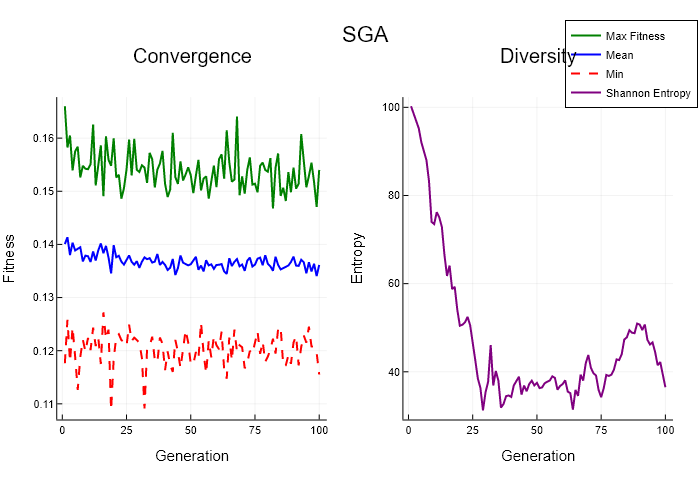

In [45]:
# Construct problem
myRNG = StableRNG(123)
problem = FeatureSelectionProblem(ncol(X), X, y, myRNG, model);

# Genetic algorithm
ga1 = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = GenerationalReplacement()
)

# Run GA
ga1_results = solve(problem, ga1)
all_feats_rmse = fitness(problem, trues(problem.n_features))

# Print results comparison
@printf("         SGA RMSE:  %.3f\n", ga1_results.min_fit)
@printf("All features RMSE:  %.3f\n\n", all_feats_rmse)

# Print and plot GA results
#print_and_plot_results(ga1_results)

display(plot_ga_summary(ga1_results, "SGA"))

## g)
#### Play with parameters of the GA and compare RMSE
1. How much are you able to improve the RMSE?
2. What is the lowest and highest RMSE you are able to get with different parameters?
3. Why do you think you get particularly low or particularly high RMSE with certain parameters?

In [23]:
using ProgressMeter
using Printf

# Store results
sga_grid_search_results = []

# Grid of params: crossover- and mutation rates
p_c_params = [0.2, 0.6, 0.9]
p_m_params = [1, 2, 4] ./ chrom_len

println("Starting Grid Search...")
println("-"^40)

# Calculate total iterations
total_iters = length(p_c_params) * length(p_m_params)
p = Progress(total_iters, dt=0.5, barglyphs=BarGlyphs("[=> ]"), barlen=50, color=:yellow)

# Run GA configurations from grid of parameters
for pc in p_c_params
    for pm in p_m_params
        # Construct problem with same RNG
        myRNG = StableRNG(123)
        problem = FeatureSelectionProblem(chrom_len, X, y, myRNG, model)
        
        # Define SGA
        ga_config = GeneticAlgorithm(
            pop_size = 100,
            max_generations = 100,
            p_c = pc,
            p_m = pm,
            chrom_len = chrom_len,
            generator = UniformRandomPopulationGenerator(),
            selector = TournamentSelectionMin(4),
            crossover = SinglePointCrossover(),
            mutator = BitFlipMutation(),
            survivor = ElitismReplacementMin(2)
        )

        # Run GA
        ga_output = solve(problem, ga_config)
        
        # Store results
        push!(sga_grid_search_results, (pc=pc, pm=pm, res=ga_output))

        # Update progress bar
        next!(p; showvalues = [
            (:Current_pc, pc), 
            (:Current_pm, round(pm, digits=4)), 
            (:Latest_Best_RMSE, round(ga_output.min_fit, digits=4))
        ])
    end
end

# Final summary
println("\n" * "="^40)
println("SGA parameter test summary")
println("="^40)

for r in sga_grid_search_results
    @printf("p_c: %.1f | p_m: %.4f | Best RMSE: %.4f\n", 
            r.pc, r.pm, r.res.min_fit)
end

Starting Grid Search...
----------------------------------------


Computing generations 100%|██████████████████████████████| Time: 0:03:34
Computing generations  14%|█████                         |  ETA: 0:03:07

LoadError: InterruptException:

#### Genetic Algorithm Configuration

| Category | Component / Parameter | Value / Implementation |
| :--- | :--- | :--- |
| **Parameters** | Population Size | 100 |
| | Max Generations | 100 |
| | Crossover Prob ($p_c$) | Variable (0.2, 0.6, 0.9) |
| | Mutation Prob ($p_m$) | Variable (1, 2, 4 / chrom_len) |
| **Operators** | Generator | Uniform Random Population |
| | Selection | Tournament Selection (t_size = 4) |
| | Crossover | Single Point Crossover |
| | Mutation | Bit Flip Mutation |
| | Survival | Elitism Replacement (n_elites = 2) |

##### Save parameter testing plots

In [ ]:
filename_base = "grid_search_plot_"

for i in 1:length(sga_grid_search_results)
    res_data = sga_grid_search_results[i].res
    save_combined_results_plot(res_data, "$(filename_base)$i.png")
end

LoadError: InterruptException:

## Run methods

In [ ]:
function reset_problem_rng()
    myRNG = StableRNG(123)
    problem = FeatureSelectionProblem(ncol(X), X, y, myRNG, model);
    return myRNG, problem
end

In [46]:
# SGA (with tournament selection)
sga = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = GenerationalReplacement()
)

# Deterministic crowding
det_crowding_ga = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = DeterministicCrowdingSelectionMin()
)

# Probabilistic crowding
prob_crowding_ga = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = ProbabilisticCrowdingSelectionMin()
)

# Elitism (k=2)
elitism_ga_k_2 = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = ElitismReplacementMin(2)
)

# Elitism (k=4)
elitism_ga_k_4 = GeneticAlgorithm(
    pop_size = 100,
    max_generations = 100,
    p_c = 0.95,
    p_m = 0.005,
    chrom_len = chrom_len,
    
    generator = UniformRandomPopulationGenerator(),
    selector = TournamentSelectionMin(4),
    crossover = SinglePointCrossover(),
    mutator = BitFlipMutation(),
    survivor = ElitismReplacementMin(4)
)

# Run GA's
rng, problem = reset_problem_rng()
sga_results = solve(problem, sga)

rng, problem = reset_problem_rng()
det_crowding_ga_results = solve(problem, det_crowding_ga)

rng, problem = reset_problem_rng()
prob_crowding_ga_results = solve(problem, prob_crowding_ga)

rng, problem = reset_problem_rng()
elitism_ga_k_2_results = solve(problem, elitism_ga_k_2)

rng, problem = reset_problem_rng()
elitism_ga_k_4_results = solve(problem, elitism_ga_k_4)

# Print results comparison
@printf("                   SGA RMSE:  %.3f\n", sga_results.min_fit)
@printf("Deterministic Crowding RMSE:  %.3f\n", det_crowding_ga_results.min_fit)
@printf(" Probablistic Crowding RMSE:  %.3f\n", prob_crowding_ga_results.min_fit)
@printf("         Elitism RMSE (k=2):  %.3f\n", elitism_ga_k_2_results.min_fit)
@printf("         Elitism RMSE (k=4):  %.3f\n", elitism_ga_k_4_results.min_fit)

Computing generations 100%|██████████████████████████████| Time: 0:02:27
Computing generations 100%|██████████████████████████████| Time: 0:02:05
Computing generations 100%|██████████████████████████████| Time: 0:02:23
Computing generations 100%|██████████████████████████████| Time: 0:02:16
Computing generations 100%|██████████████████████████████| Time: 0:02:04


                   SGA RMSE:  0.111
Deterministic Crowding RMSE:  0.108
 Probablistic Crowding RMSE:  0.110


LoadError: FieldError: type GeneticAlgorithm has no field `min_fit`, available fields: `p_c`, `p_m`, `pop_size`, `max_generations`, `chrom_len`, `generator`, `selector`, `crossover`, `mutator`, `survivor`

### Create plots

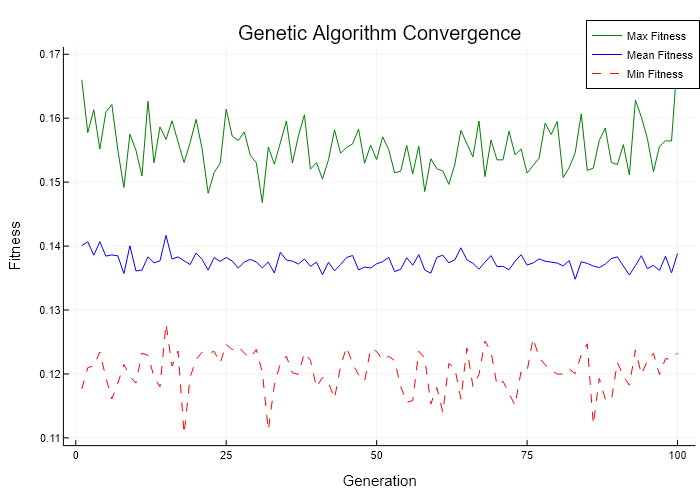

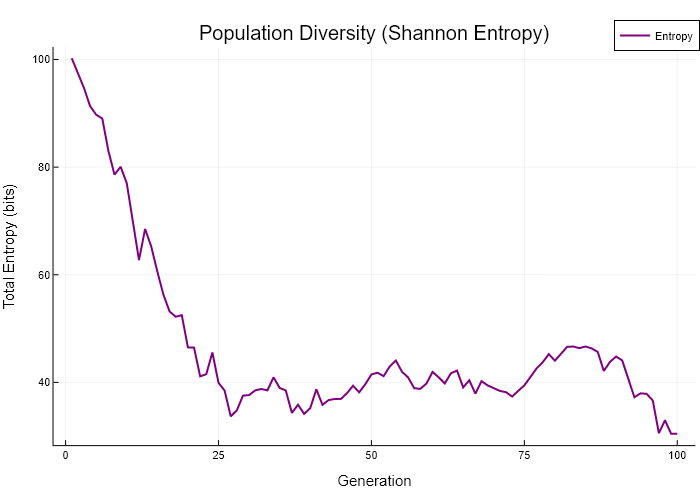

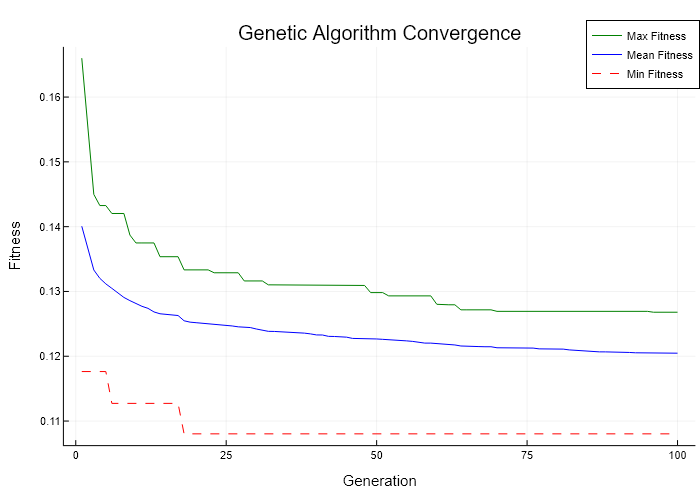

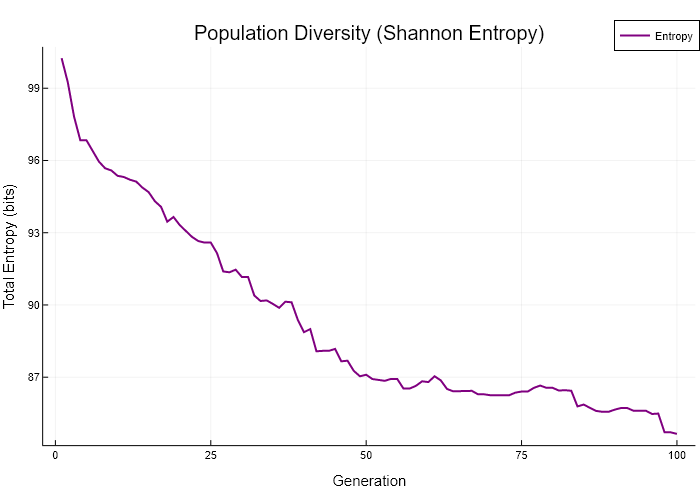

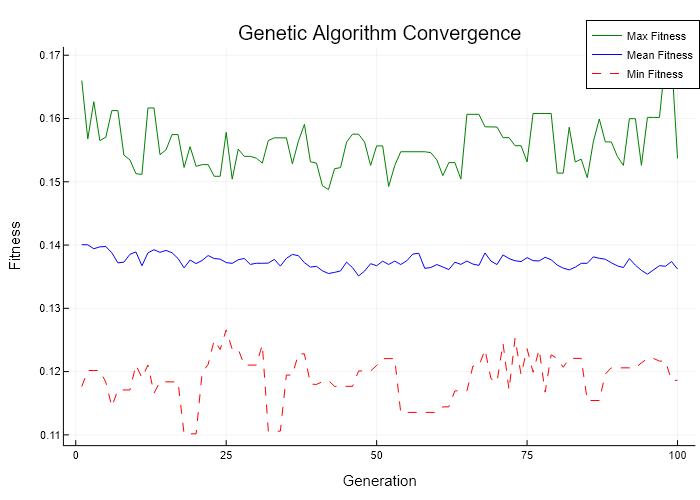

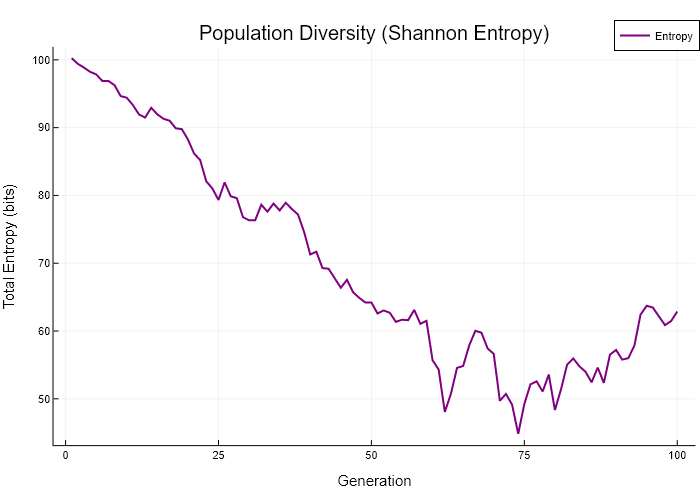

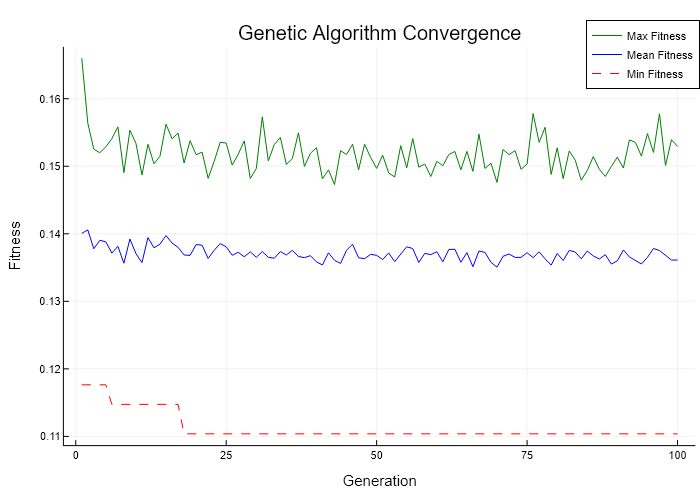

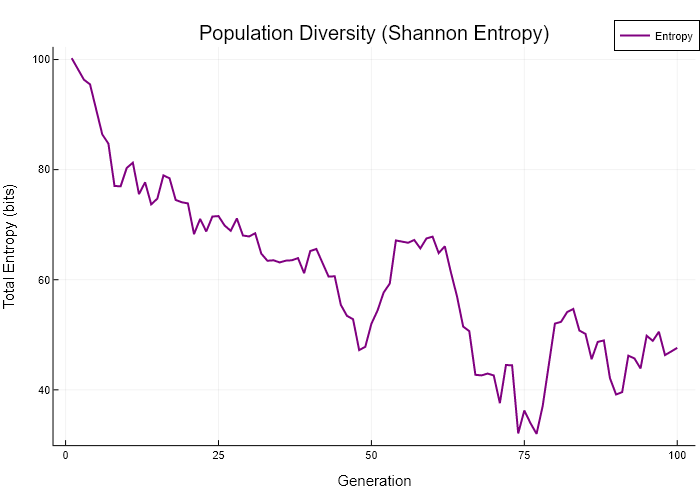

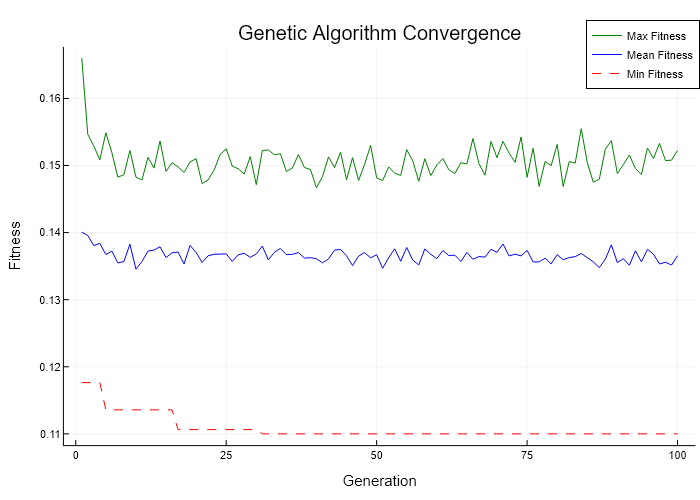

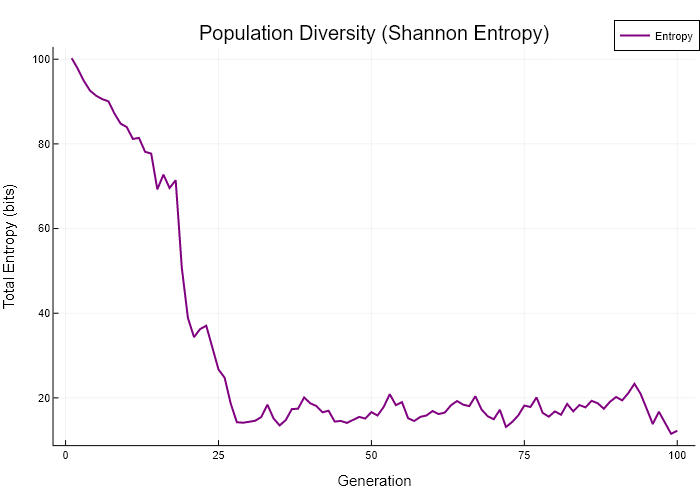

In [65]:
plot_sga_fit = plot_ga_convergence(sga_results)
plot_sga_entropy = plot_ga_entropy(sga_results)

plot_det_crowd_fit = plot_ga_convergence(det_crowding_ga_results)
plot_det_crowd_entropy = plot_ga_entropy(det_crowding_ga_results)

plot_prob_crowd_fit = plot_ga_convergence(prob_crowding_ga_results)
plot_prob_crowd_entropy = plot_ga_entropy(prob_crowding_ga_results)

plot_elite_k_2_fit = plot_ga_convergence(elitism_ga_k_2_results)
plot_elite_k_2_entropy = plot_ga_entropy(elitism_ga_k_2_results)

plot_elite_k_4_fit = plot_ga_convergence(elitism_ga_k_4_results)
plot_elite_k_4_entropy = plot_ga_entropy(elitism_ga_k_4_results)


#### Display plots
display(plot_sga_fit)
display(plot_sga_entropy)

display(plot_det_crowd_fit)
display(plot_det_crowd_entropy)

display(plot_prob_crowd_fit)
display(plot_prob_crowd_entropy)

display(plot_elite_k_2_fit)
display(plot_elite_k_2_entropy)

display(plot_elite_k_4_fit)
display(plot_elite_k_4_entropy)

### Save plots

In [66]:
savefig(plot_sga_fit, "plot_sga_fit.png")
savefig(plot_sga_entropy, "plot_sga_entropy.png")

savefig(plot_det_crowd_fit, "plot_det_crowd_fit.png")
savefig(plot_det_crowd_entropy, "plot_det_crowd_entropy.png")

savefig(plot_prob_crowd_fit, "plot_prob_crowd_fit.png")
savefig(plot_prob_crowd_entropy, "plot_prob_crowd_entropy.png")

savefig(plot_elite_k_2_fit, "plot_elite_k_2_fit.png")
savefig(plot_elite_k_2_entropy, "plot_elite_k_2_entropy.png")

savefig(plot_elite_k_4_fit, "plot_elite_k_4_fit.png")
savefig(plot_elite_k_4_entropy, "plot_elite_k_4_entropy.png")


"C:\\Users\\Olav\\Documents\\_Master\\IT3708 - Bio KI\\Projects\\Project_1\\plot_elite_k_4_entropy.png"

### Print results

In [68]:
#### Print final entropies
@printf("                   SGA entropy:  %.3f\n", sga_results.hist_entropy[100])
@printf("Deterministic Crowding entropy:  %.3f\n", det_crowding_ga_results.hist_entropy[100])
@printf("Deterministic Crowding entropy:  %.3f\n", prob_crowding_ga_results.hist_entropy[100])
@printf("         Elitism (k=2) entropy:  %.3f\n", elitism_ga_k_2_results.hist_entropy[100])
@printf("         Elitism (k=4) entropy:  %.3f\n", elitism_ga_k_4_results.hist_entropy[100])

                   SGA entropy:  30.434
Deterministic Crowding entropy:  84.648
Deterministic Crowding entropy:  62.884
         Elitism (k=2) entropy:  47.622
         Elitism (k=4) entropy:  12.227


In [69]:
#### Print best RMSE
@printf("                   SGA RMSE:  %.3f\n", sga_results.min_fit)
@printf("Deterministic Crowding RMSE:  %.3f\n", det_crowding_ga_results.min_fit)
@printf("Deterministic Crowding RMSE:  %.3f\n", prob_crowding_ga_results.min_fit)
@printf("         Elitism (k=2) RMSE:  %.3f\n", elitism_ga_k_2_results.min_fit)
@printf("         Elitism (k=4) RMSE:  %.3f\n", elitism_ga_k_4_results.min_fit)

                   SGA RMSE:  0.111
Deterministic Crowding RMSE:  0.108
Deterministic Crowding RMSE:  0.110
         Elitism (k=2) RMSE:  0.110
         Elitism (k=4) RMSE:  0.110
